<img src="KyleDevLogo.jpg" alt="Kyles Logo" style="width: 50rem; border-radius: 2%;" />

# **Heart Failure Prediction**
By: Kyle Hostetter

## Data Information

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure. Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies. People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Columns**
* age- The age of the person
* anaemia- Decrease of red blood cells or hemoglobin
* creatinine_phosphokinase- Level of the CPK enzyme in the blood (mcg/L)
* diabetes- If the patient has diabetes
* ejection_fraction- Percentage of blood leaving the heart at each contraction
* high_blood_pressure- If the patient has hypertension
* platelets- Platelets in the blood (kiloplatelets/mL)
* serum_creatinine- Level of serum creatinine in the blood (mg/dL)
* serum_sodium- Level of serum sodium in the blood (mEq/L)
* sex- Woman or man 
* smoking- If the patient smokes or not
* time- Follow-up period (days)
* DEATH_EVENT- If the patient deceased during the follow-up period

## Import Libraries

In [144]:
'''
Title: Heart Failure Prediction System
Author: Kyle Hostetter
Date: 04-02-2023
Description: A simple classifiacation of the Heart Failure. 
'''

# Import Core Libraries
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Deep Learning Libraries
import keras
import tensorflow as tf
from keras import layers

# Import Metric & Preprocessing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, recall_score
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report

# Import Machine Learning Libraries
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Add SelfMadeFunctions to Path
sys.path.insert(0,'../../../../Data-Science-Portfolio/')

# Import Self Made Functions
from SelfMadeFunctions import *

# Set Theme for graphs
sns.set_theme(palette='bright')

## Data Overview

In [145]:
# Assign CSV to a dataframe 
df = pd.read_csv('HeartData.csv')
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


DataFrame Observations-
* We can see that we have 13 columns here. No data seems to be useless. Nothing we can see right off the bat. This seems like al proper dataset.
* We can also see that this dataset has 299 rows of data as well. 
* After reading the background info about the dataset, we will need to split our dataset into continuous and categorical columns.

#### DataFrame Info

In [146]:
# Show all dataFrame info
# Create a dataframe version of df.info()
infoOut(df)

,Column,Non-Null Count,NULL Count,Dtype
0,age,299,0,float64
1,anaemia,299,0,int64
2,creatinine_phosphokinase,299,0,int64
3,diabetes,299,0,int64
4,ejection_fraction,299,0,int64
5,high_blood_pressure,299,0,int64
6,platelets,299,0,float64
7,serum_creatinine,299,0,float64
8,serum_sodium,299,0,int64
9,sex,299,0,int64


#### Null Values

In [147]:
# NULL Value checks
nullValues(df)

,NULL Amounts
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


NULL Oberservations-
* There are no NULL values in this dataset which is PERFECT!

#### Duplicated Rows

In [148]:
# Duplicate Values
display(df.duplicated().sum())

0

Duplicate Observations-
* There are no duplicated rows in this dataset which is PERFECT!

#### Unique Values

In [149]:
# Print out Categorical Columns
for col in df.columns:

    # If there are more than 2 unique values in that column, skip it
    if len(df[col].unique()) > 2:
        pass
    else: 
        # Display the categorical column and its values.
        display(df[col].value_counts().to_frame())

,count
anaemia,
0,170
1,129


,count
diabetes,
0,174
1,125


,count
high_blood_pressure,
0,194
1,105


,count
sex,
1,194
0,105


,count
smoking,
0,203
1,96


,count
DEATH_EVENT,
0,203
1,96


Unique Value Obeservations-
* We can see that these are going to be the categorical columns. This was inferred by the background information.
* There are a total of 6 categorical columns.

#### Split Columns into Categorical or Continuous Lists

In [150]:
# Categorical Columns
cat_columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 
               'DEATH_EVENT']

# Continuous Columns
con_columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
               'platelets', 'serum_creatinine', 'serum_sodium', 'time']

# Target column
target_column =['DEATH_EVENT']

## Exploritory Data Analysis

### Univariate Analysis

#### Basic Statistics

In [151]:
# Print out basic statistics about dataframe
df[con_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0


Basic Statistics Observations-
* 

#### Continuous Analysis

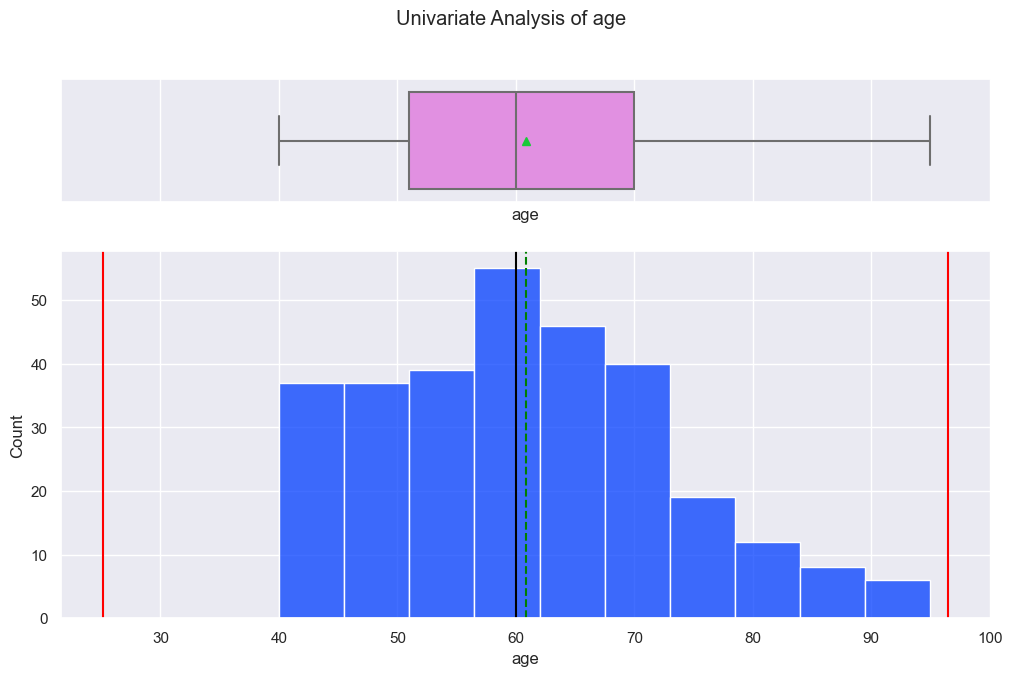

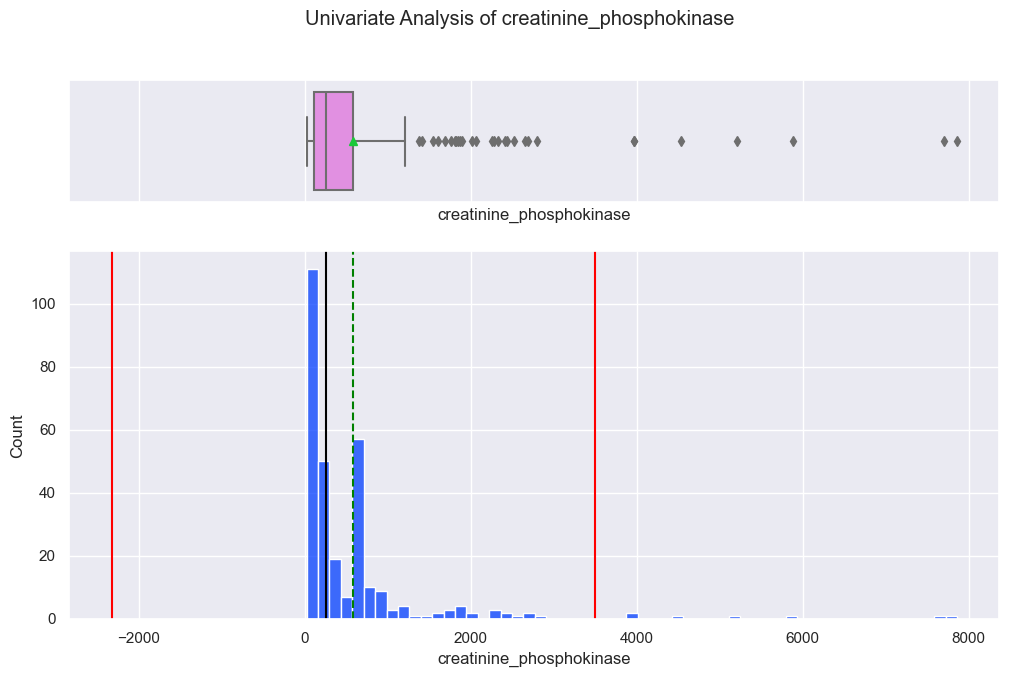

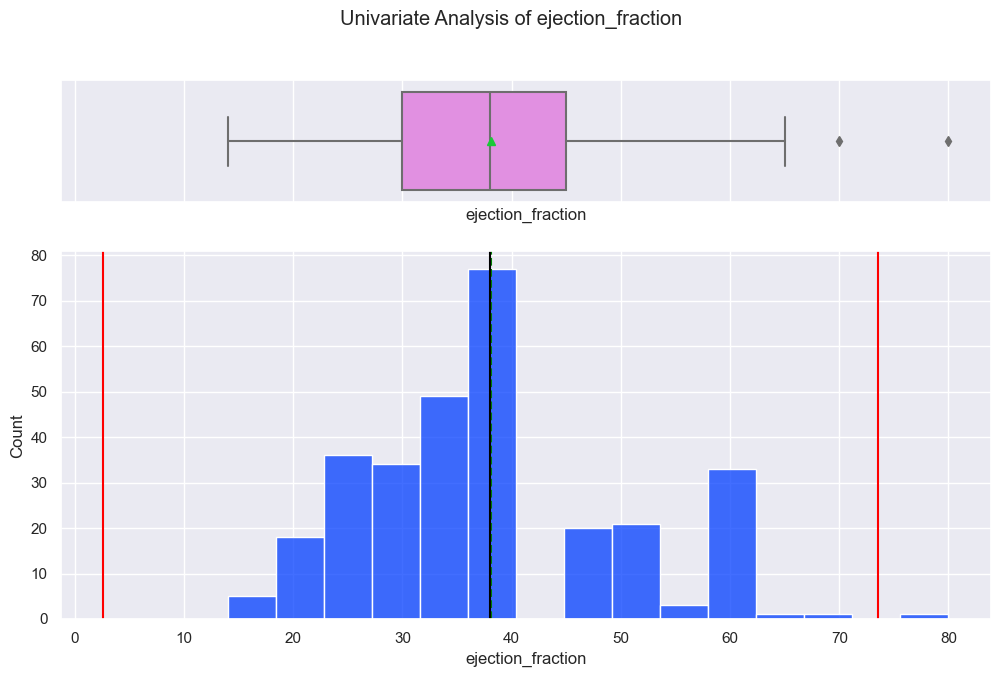

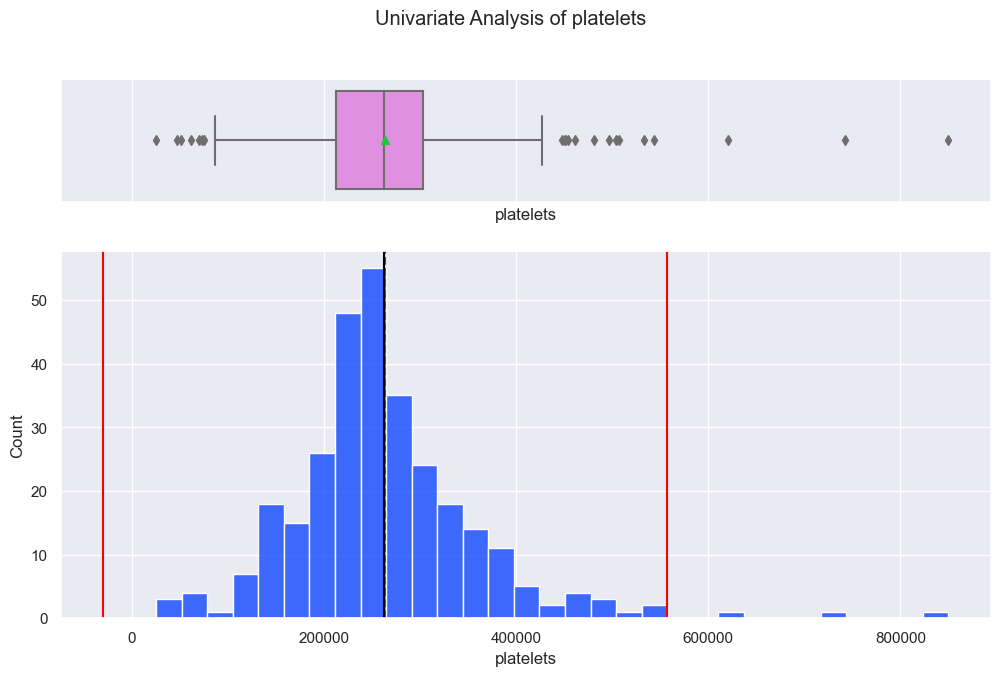

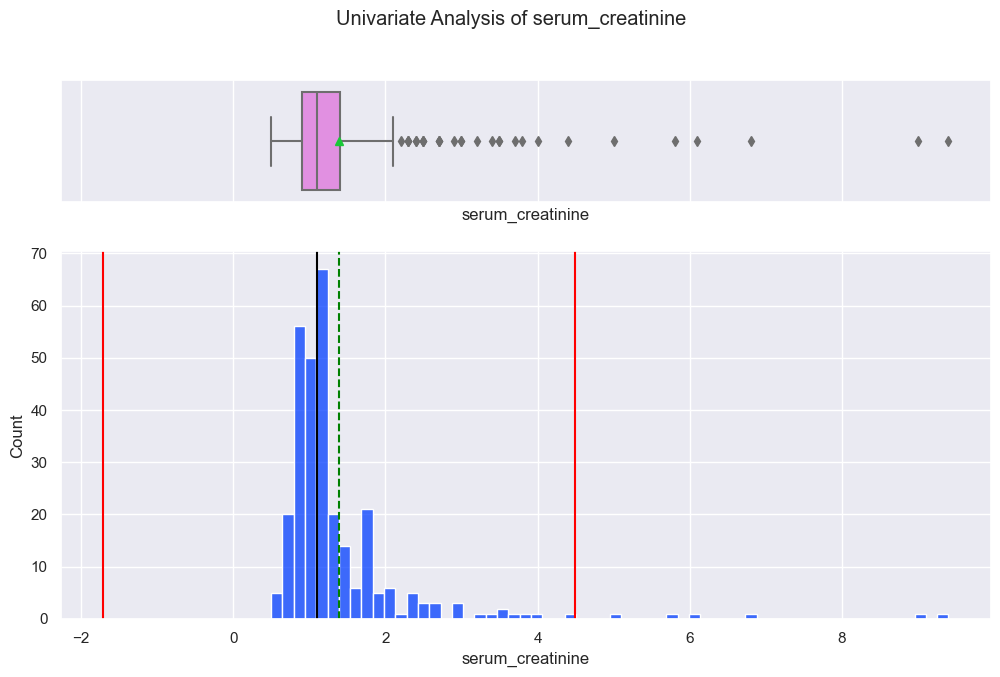

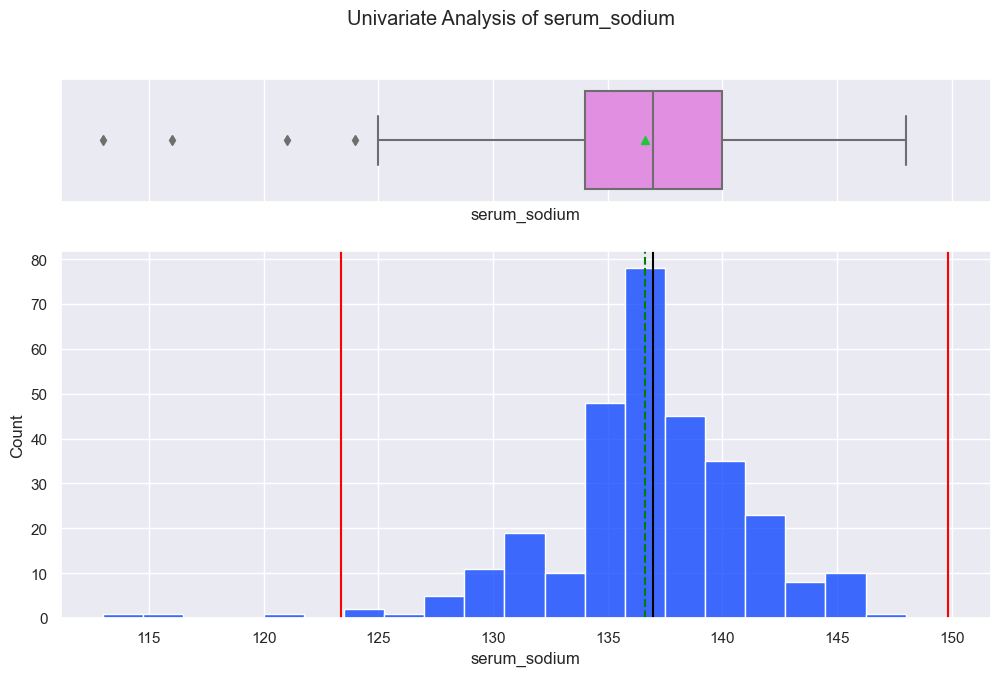

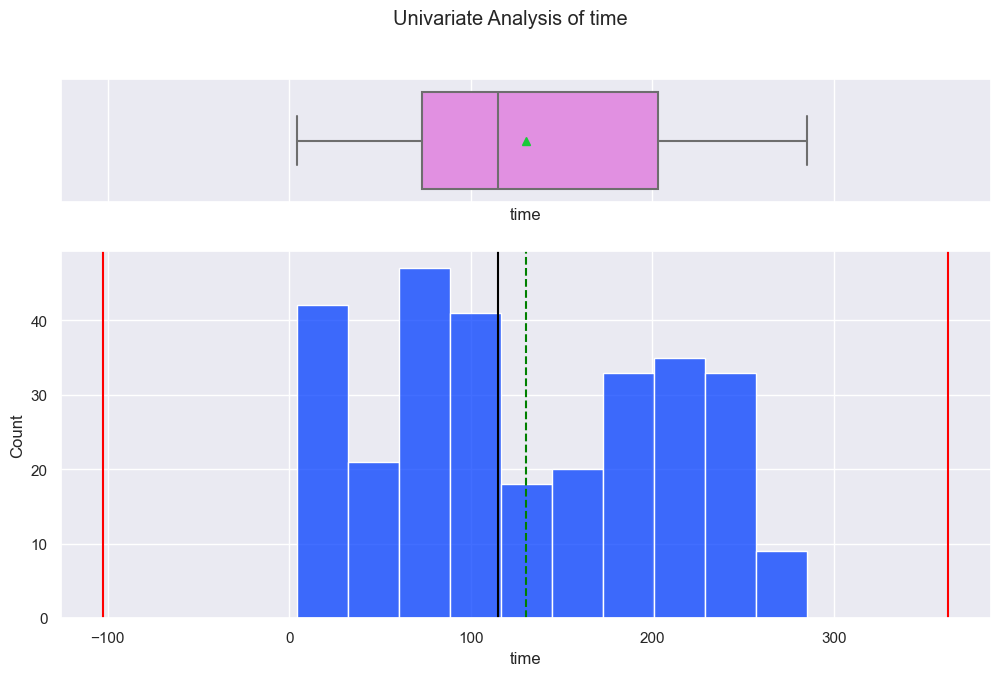

In [152]:
# Show box plots and histograms for all continuous Columns
for col in con_columns:
    # Run the visualization function
    histogram_boxplot(data=df,      # DataFrame
                      feature=col)  # The column the create visualization for

Continuous Column Observations-
* age: 
    - Distribution: Right Skewed
    - Skewness: Slight right
    - Outliers: None
    - Log Transformation Needed: No
<br></br>
* creatinine_phosphokinase: 
    - Distrubtion: Strong right
    - Skewness: Strong right
    - Outliers: A lot, all greater than the mean
    - Log Transformation Needed: Most likely
<br></br>
* ejection_fraction: 
    - Distibution: Somewhat Normal
    - Skewness: Slight right
    - Outliers: 2, all greater than the mean 
    - Log Transformation Needed: None
<br></br>
* platelets: 
    - Distribution: Normal
    - Skewness: None
    - Outliers: Alot, Both sides of the mean
    - Log Transformation Needed: None
<br></br>
* serum_creatinine:
    - Disribution: Skew rith
    - Skewness: Slight right
    - Outliers: Alot, All greater than the mean
    - Log Transformation Needed: Most likely
<br></br>
* serum_sodium: 
    - Distribution: Normal 
    - Skewness: No
    - Outliers: 4, All less than the mean
    - Log Transformation Needed: Nome
<br></br>
* time:
    - Distribution: MultiModal
    - Skewness: None
    - Outliers: None
    - Log Transformation Needed: None

#### Log Transformations

DataFrame with log transformations


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,log_creatinine_phosphokinase,log_serum_creatinine
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,6.366470,0.641854
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,8.969669,0.095310
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,4.983607,0.262364
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,4.709530,0.641854
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,5.075174,0.993252


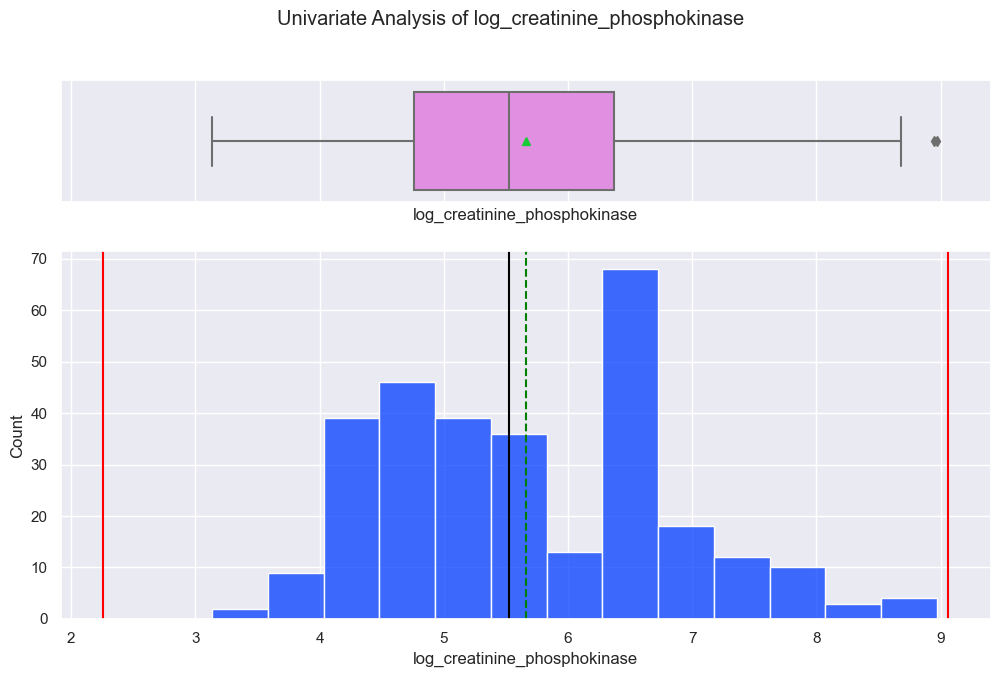

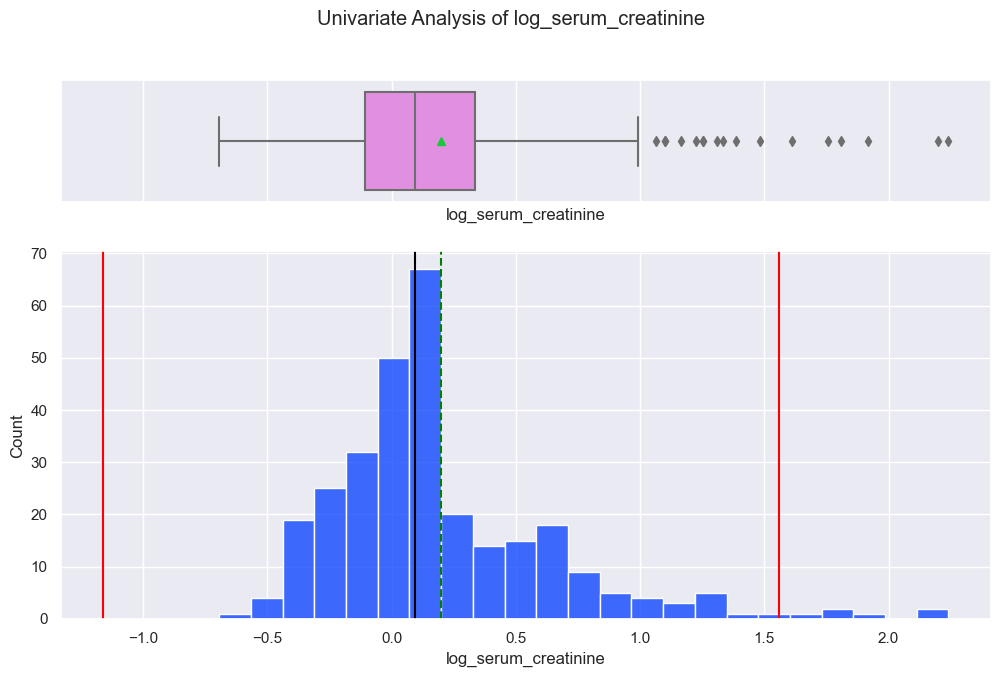

In [153]:
# Create lists of columns that need log transformations
log_columns= ['creatinine_phosphokinase','serum_creatinine']
log_column_names= []

# Create loop to add the log transformations for each column in log_columns
for col in log_columns:
    logged_column_name = 'log_'+ col                # Create a new column for log transformations
    df[logged_column_name] = np.log(df[col])        # Perform the log transformation on column and put it into the dataframe
    log_column_names.append(logged_column_name)     # Add log_ + column_name to the empty list
    con_columns.append(logged_column_name)          # Add log_ + column_name to continuous columns list
    
# Show the new dataframe
print('DataFrame with log transformations')
display(df.head())
print(' ')

# Create Visualizations for each log transformed Column
for col in log_column_names:
    histogram_boxplot(df, col)  # Create a histogram & boxplot for each column

Log Transformations Oberservations-
* log_creatinine_phosphokinase
    - We can see that there is more normal distribution, but does have a multimodal distribution.
<br></br>
* log_serum_creatinine
    - There now seems to be a more normal distribution. But there is a slight skew to the right.

#### Categorical Analysis

In [154]:
# Copy Dataframe for visualizations
df_cat = df.copy()

# Mapping of DataFrame 
columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']
for col in columns:
  df_cat[col] = df_cat[col].map({0:'No', 1:'Yes'})

# Mapping sex columns
df_cat['sex'] = df_cat['sex'].map({0:'Female', 1:'Male'})

# Display DataFrame
df_cat

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,log_creatinine_phosphokinase,log_serum_creatinine
0,75.0,No,582,No,20,Yes,265000.00,1.9,130,Male,No,4,Yes,6.366470,0.641854
1,55.0,No,7861,No,38,No,263358.03,1.1,136,Male,No,6,Yes,8.969669,0.095310
2,65.0,No,146,No,20,No,162000.00,1.3,129,Male,Yes,7,Yes,4.983607,0.262364
3,50.0,Yes,111,No,20,No,210000.00,1.9,137,Male,No,7,Yes,4.709530,0.641854
4,65.0,Yes,160,Yes,20,No,327000.00,2.7,116,Female,No,8,Yes,5.075174,0.993252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,No,61,Yes,38,Yes,155000.00,1.1,143,Male,Yes,270,No,4.110874,0.095310
295,55.0,No,1820,No,38,No,270000.00,1.2,139,Female,No,271,No,7.506592,0.182322
296,45.0,No,2060,Yes,60,No,742000.00,0.8,138,Female,No,278,No,7.630461,-0.223144
297,45.0,No,2413,No,38,No,140000.00,1.4,140,Male,Yes,280,No,7.788626,0.336472


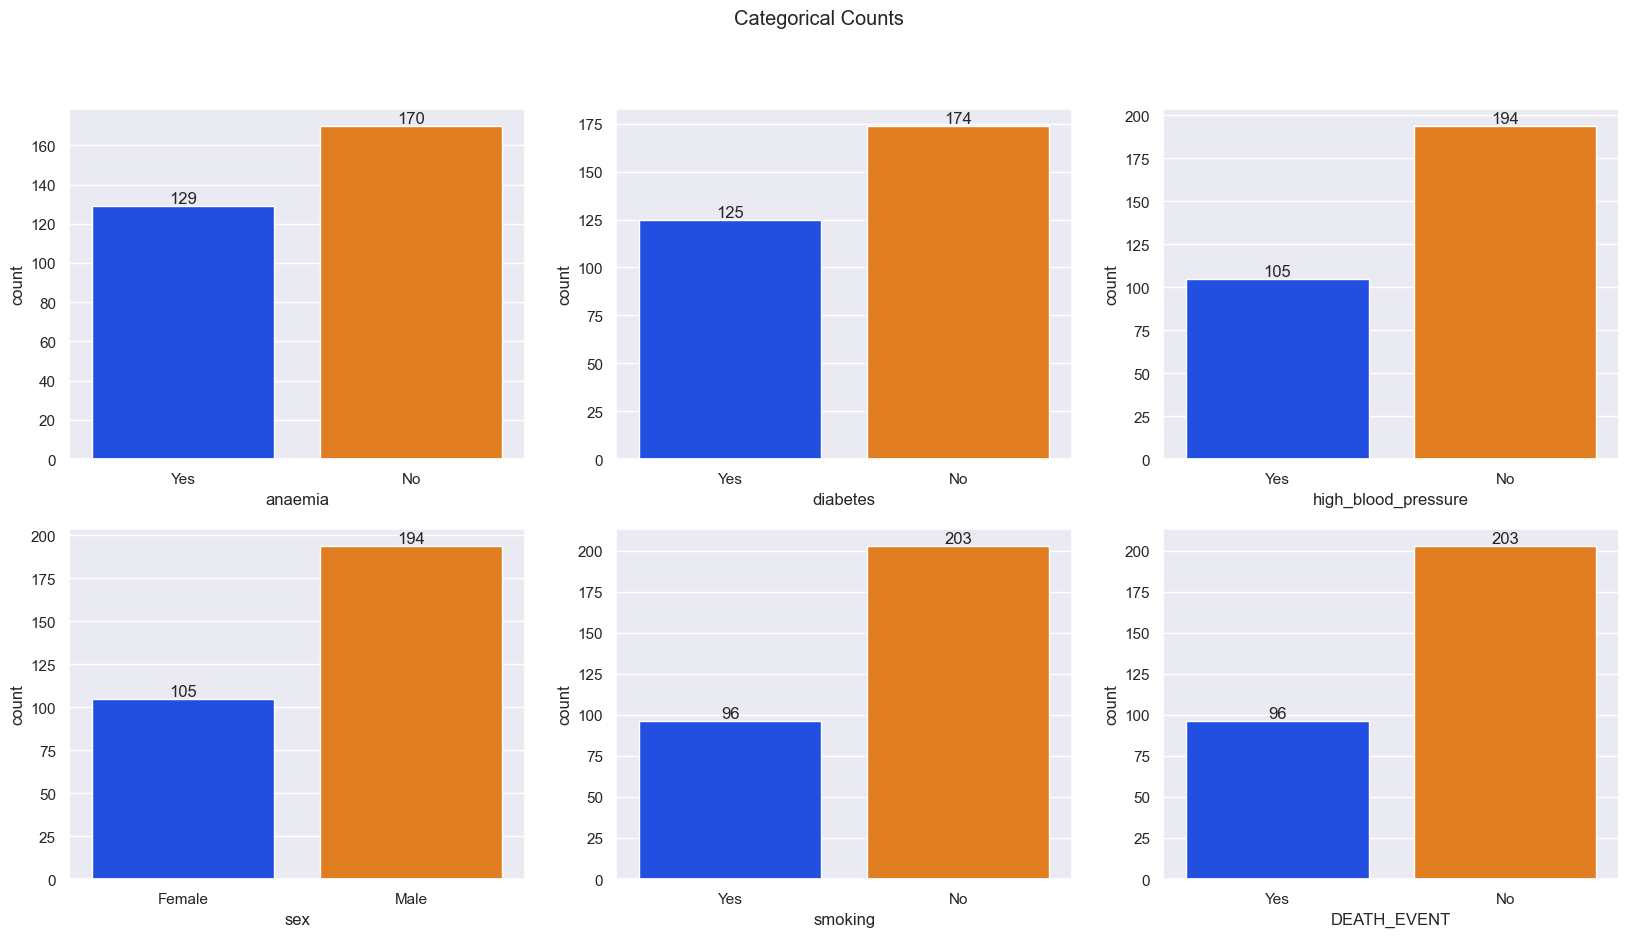

In [155]:
# Visualization of Categorical Columns
categoricalVisualizations(figsize=(20,10),             # Figures (Width,Height)         
                          title='Categorical Counts',  # Title of Figure                     
                          rows=2,                      # Amount of rows   
                          columns=3,                   # Amount of columns     
                          dataFrame=df_cat,            # DataFrame         
                          cat_columns=cat_columns)     # Categorical Columns  

Categorical Column Observations-
* anaemia
    - This column has the smallest difference between the two values.
<br></br>
* diabetes
    - This column has the smallest difference between the two values.
<br></br>
* high_blood_pressure
    - There seems to be more than 40% more people not having high blood pressure than having high blood pressure.
<br></br>
* sex
    - There seems are over 45% more Male cases than Female cases in this dataset.
<br></br>
* smoking
    - There is a significant amount of people that don't smoke rather than do smoke. 
<br></br>
* DEATH_EVENT
    - There seems to be more than double none deaths than death events. This could cause an issue in our final data set. There might need to be random sampling done later.

### BiVariate Analysis

Text(0.5, 1.0, 'Continuous Variable Correlations')

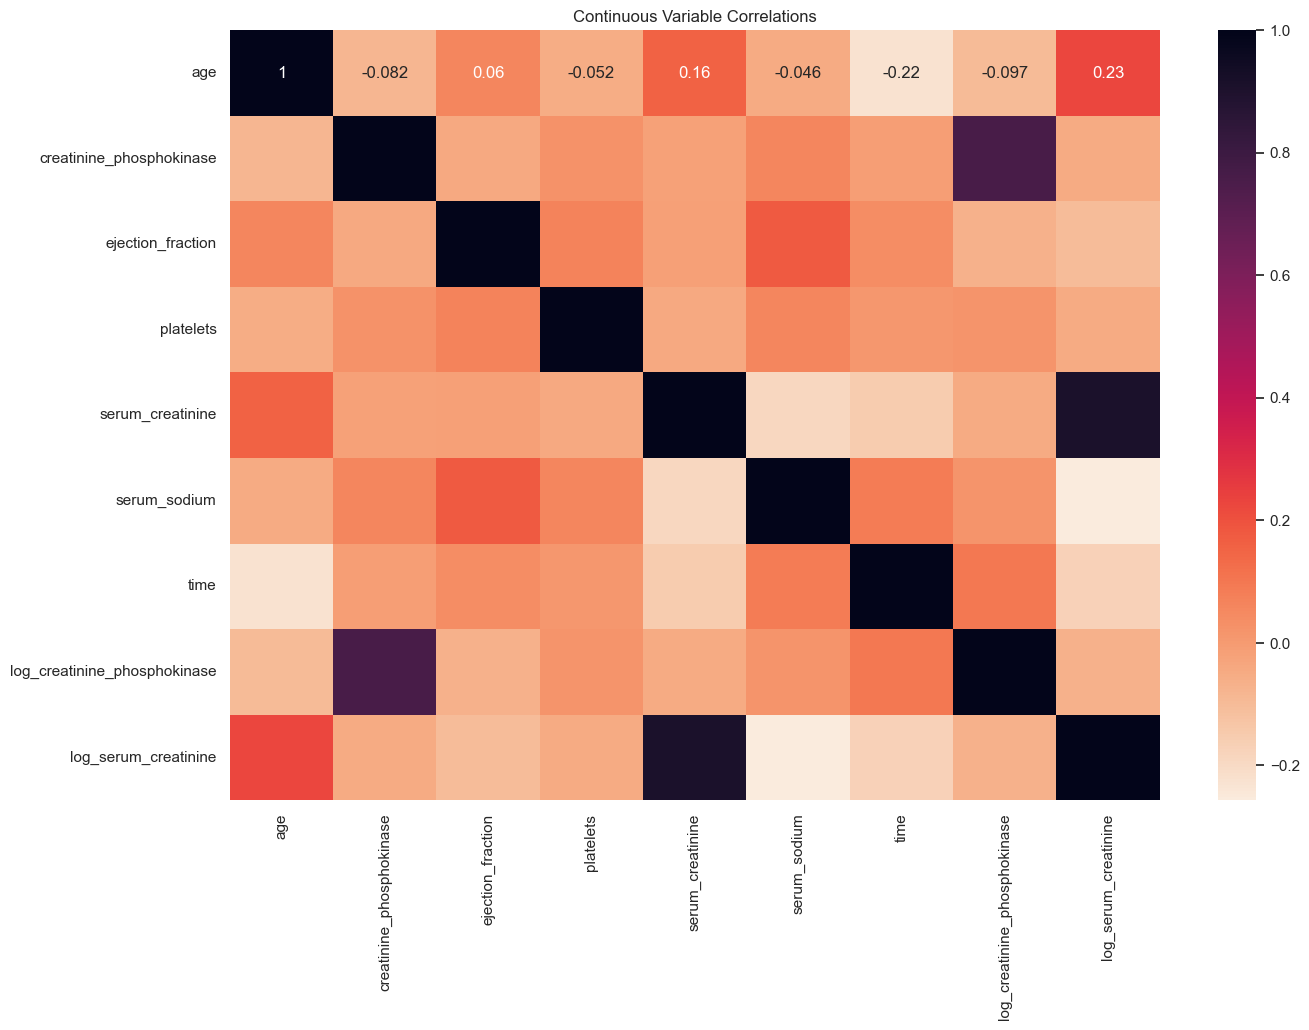

In [156]:
# Create heatmap correlations

# Set size of chart
plt.figure(figsize=(15,10))

# Create Heatmap
sns.heatmap(df[con_columns].corr(),          # Correlation chart
            annot=True,         # Add correlation value in each box
            cmap="rocket_r")    # Add color palette

# Set title of chart
plt.title('Continuous Variable Correlations')

Heatmap Correlation Observations-
* There are not correlations that are strong between any columns.
* The only strong correlations seem to be the ones that are log transformed to their non-log transformed counterparts.

#### Categorical Analysis

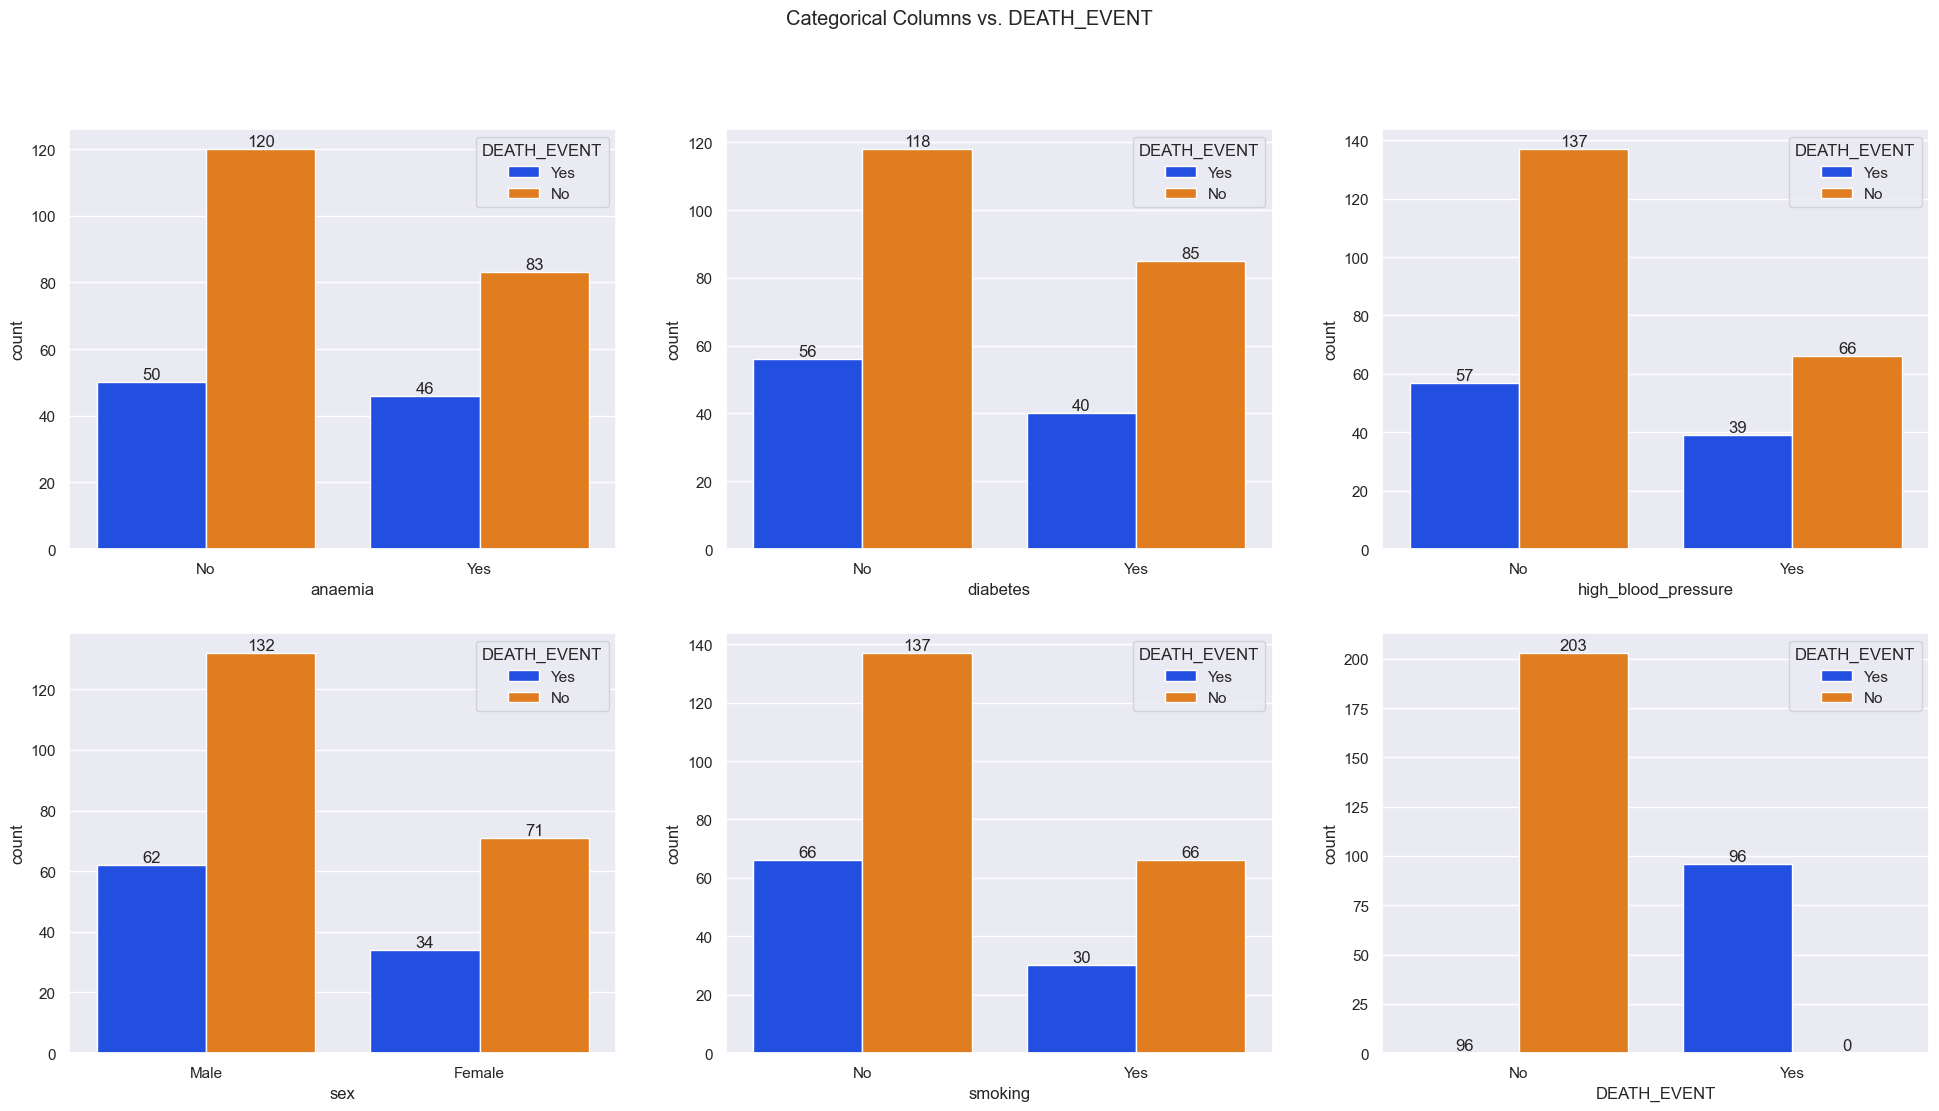

In [157]:
# Choose Size of Chart
plt.figure(figsize=(24,12))
plt.suptitle('Categorical Columns vs. DEATH_EVENT')

# Set loop value for i
i=0

# Create for loop
for col in cat_columns:
    
    # Iterate through subplots
    plt.subplot(2,3,i+1)

     # Show visualizations
    ax = sns.countplot(data=df_cat,                                       # Remapped df for categoical labels
                  x=col,                                                  # Column name
                  hue='DEATH_EVENT',                                      # Show difference color for different value for DEATH_EVENT
                  order=df_cat[col].value_counts(ascending=False).index)  # Order of values
    
    # Add Label values to chart
    yes_values = df_cat.loc[df_cat['DEATH_EVENT'] == 'Yes'][col].value_counts(ascending=False).values   # Calculate YES value counts
    no_values = df_cat.loc[df_cat['DEATH_EVENT'] == 'No'][col].value_counts(ascending=False).values     # Calculate NO value counts

    ax.bar_label(container=ax.containers[0], labels=yes_values)   # Add value counts to each bar in chart
    ax.bar_label(container=ax.containers[1], labels=no_values)    # Add value counts to each bar in chart         
    i = i+1  # Increment i by 1

Categorical Column Observations-

* anaemia
    - There does not seem to be any numbers that catch my eye.
<br></br>
* diabetes
    - There are more deaths for people who don't have diabetes than do.
<br></br>
* high_blood_pressure
    - There are more deaths for people who don't have high blood pressure than do.
<br></br>
* sex
    - There are more males death events than females. There are about 40%+ more.
<br></br>
* smoking
    - There were more deaths for people who didn't smoke than people who smoked. To be honest this one shocks me.

## Data Preprocessing

In [158]:
# Assign Data for Features and Targets
X = df.drop(columns=['DEATH_EVENT','serum_creatinine', 'creatinine_phosphokinase'])
y = df['DEATH_EVENT']

# # Scale Features 
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_array = np.array(X)

# Seperate into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0, stratify=df['DEATH_EVENT'])

Data Preprocessing Obeservations-
* There is no need to encode any values in the dataframe.
* We dropped the traget column, and then serum_creatinine and creatinine_phosphokinase since their log transformations added more information to the dataframe than their regular columns.

## Machine Learning

#### Classification Model

In [159]:
# Machine Learning Classifiers
classifier_list = [ SVC(random_state=0),
                    GaussianNB(), 
                    XGBClassifier(random_state=0), 
                    MLPClassifier(random_state=0), 
                    LogisticRegression(random_state=0),
                    AdaBoostClassifier(random_state=0),  
                    KNeighborsClassifier(),  
                    DecisionTreeClassifier(random_state=0),       
                    RandomForestClassifier(random_state=0), 
                    QuadraticDiscriminantAnalysis()]     

 # Classifier Names
class_name = ['SVC',
              'GaussianNB', 
              'XGBClassifier',
              'MLPClassifier',
              'LogisticRegression',
              'AdaBoostClassifier',  
              'KNeighborsClassifier',  
              'DecisionTreeClassifier',       
              'RandomForestClassifier', 
              'QuadraticDiscriminantAnalysis']

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # Classification list
                  classifier_name=class_name,    # Classifier name
                  X=X,                           # X data
                  y=y,                           # Y data
                  X_train=X_train,               # X_train Dataset
                  y_train=y_train,               # y_train Dataset
                  X_test=X_test,                 # X_test Dataset
                  y_test=y_test,                 # y_test Dataset
                  kfolds=5)                      # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833
0,SVC,0.000000,0.000000,0.524984,0.000000,0.679167
3,MLPClassifier,0.000000,0.000000,0.519239,0.000000,0.679167




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
1,GaussianNB,0.736842,0.875000,0.844031,0.800000,0.883333
7,DecisionTreeClassifier,0.842105,0.727273,0.847882,0.780488,0.850000
8,RandomForestClassifier,0.736842,0.777778,0.819641,0.756757,0.850000
4,LogisticRegression,0.684211,0.812500,0.805520,0.742857,0.850000
5,AdaBoostClassifier,0.736842,0.736842,0.807445,0.736842,0.833333
2,XGBClassifier,0.684211,0.722222,0.781130,0.702703,0.816667
9,QuadraticDiscriminantAnalysis,0.421053,0.727273,0.673941,0.533333,0.766667
6,KNeighborsClassifier,0.210526,0.444444,0.544288,0.285714,0.666667
0,SVC,0.000000,0.000000,0.500000,0.000000,0.683333
3,MLPClassifier,0.000000,0.000000,0.500000,0.000000,0.683333


Classification Metrics Obeservations-
* We can see that our scores overall are not too great. The Test scores seem to be good and solid. However when doing a further analysis with cross validation we can see that our scores are just at .804 accuracy and .74 F1-score.
* Our top 3 classifiers are Logisitic Regression, GaussianNB, Quadratic Discriminant Analysis.
* The reason we are going with the models that are in the cross validation section is because cross validation gives a better overall accuracy for what the classifier predicts. Showing in turn, more accurate results.

#### Model Analysis

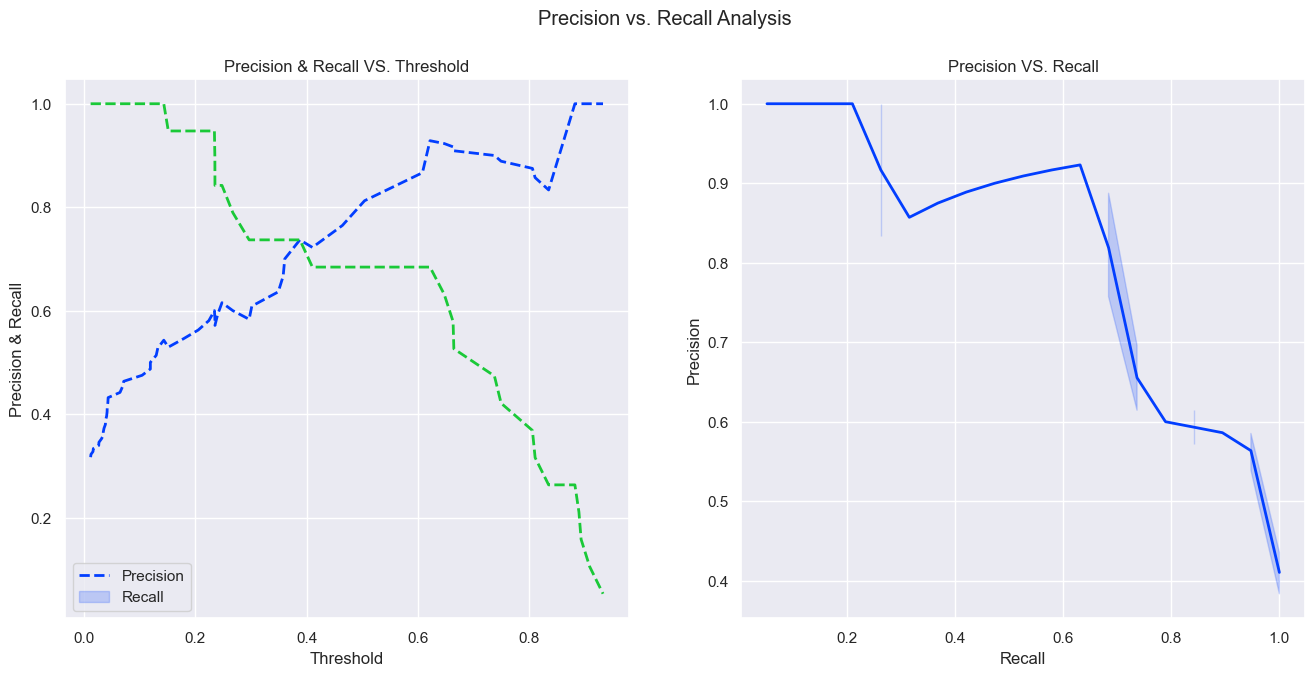

In [160]:
# Train and Predict model
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train, y_train)
y_proba = log_model.predict_proba(X_test)

# Visualize Pecision & Recall 
precisionRecallAnalysis(y_test, y_proba)

Precision & Recall Analysis Obeservations-
* We can see that the optimal threshold is right about .4 to optimize precision and recall.

#### Hypertuning

In [161]:
# Logisitic Regression Parameteres
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty': ['none', 'l2']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'max_iter': [10,100, 1000]},
              {'random_state': [0,3,5,10,15]}]

# Define Parameters for optimization
optimized_model = GridSearchCV(estimator=log_model,     # Final machine learning model to optimize 
                               param_grid=parameters,   # List of parameters for machine learning model
                               scoring = 'f1',          # Scoring for classification
                               cv=5,                    # Rounds of training for each parameter combo
                               n_jobs=-1)               # Number of CPU threads to use. We are using all avialble here.

# Optmize model Train and Prediction
optimized_model.fit(X_train, y_train)

# Add this model to classifier list
classifier_list.append(optimized_model)
class_name.append('Optimized Logistic Regression')

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,
                  classifier_name=class_name,
                  X=X,                  # X data
                  y=y,                  # Y data
                  X_train=X_train,      # X_train Dataset
                  y_train=y_train,      # y_train Dataset
                  X_test=X_test,        # X_test Dataset
                  y_test=y_test,        # y_test Dataset
                  kfolds=5)             # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833
0,SVC,0.000000,0.000000,0.524984,0.000000,0.679167




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
1,GaussianNB,0.736842,0.875000,0.844031,0.800000,0.883333
7,DecisionTreeClassifier,0.842105,0.727273,0.847882,0.780488,0.850000
10,Optimized Logistic Regression,0.736842,0.823529,0.831836,0.777778,0.866667
8,RandomForestClassifier,0.736842,0.777778,0.819641,0.756757,0.850000
4,LogisticRegression,0.684211,0.812500,0.805520,0.742857,0.850000
5,AdaBoostClassifier,0.736842,0.736842,0.807445,0.736842,0.833333
2,XGBClassifier,0.684211,0.722222,0.781130,0.702703,0.816667
9,QuadraticDiscriminantAnalysis,0.421053,0.727273,0.673941,0.533333,0.766667
6,KNeighborsClassifier,0.210526,0.444444,0.544288,0.285714,0.666667
0,SVC,0.000000,0.000000,0.500000,0.000000,0.683333


Hypertuning Observations-
* We can see that there was no increase in our F1 score. So this model does not out perfrom the default Logistic Regression model.
* We can see that there was an increase in the test scores. But this is not what we are going to evaluate our model on. The cross validation is more accurate in terms of metrics.
* Next we are going to build a ensemble model of the top 3 classifiers to increase our scores.

#### Feature Importance

   Logisitic Regression Feature Importance
----------------------------------------


,index,Feature,Scoring
0,3,ejection_fraction,0.070730
1,0,age,0.042703
2,9,time,0.018902
3,6,serum_sodium,0.012674
4,10,log_creatinine_phosphokinase,0.004432
5,11,log_serum_creatinine,0.003222
6,1,anaemia,0.000373
7,2,diabetes,0.000361
8,8,smoking,0.000230
9,7,sex,0.000163


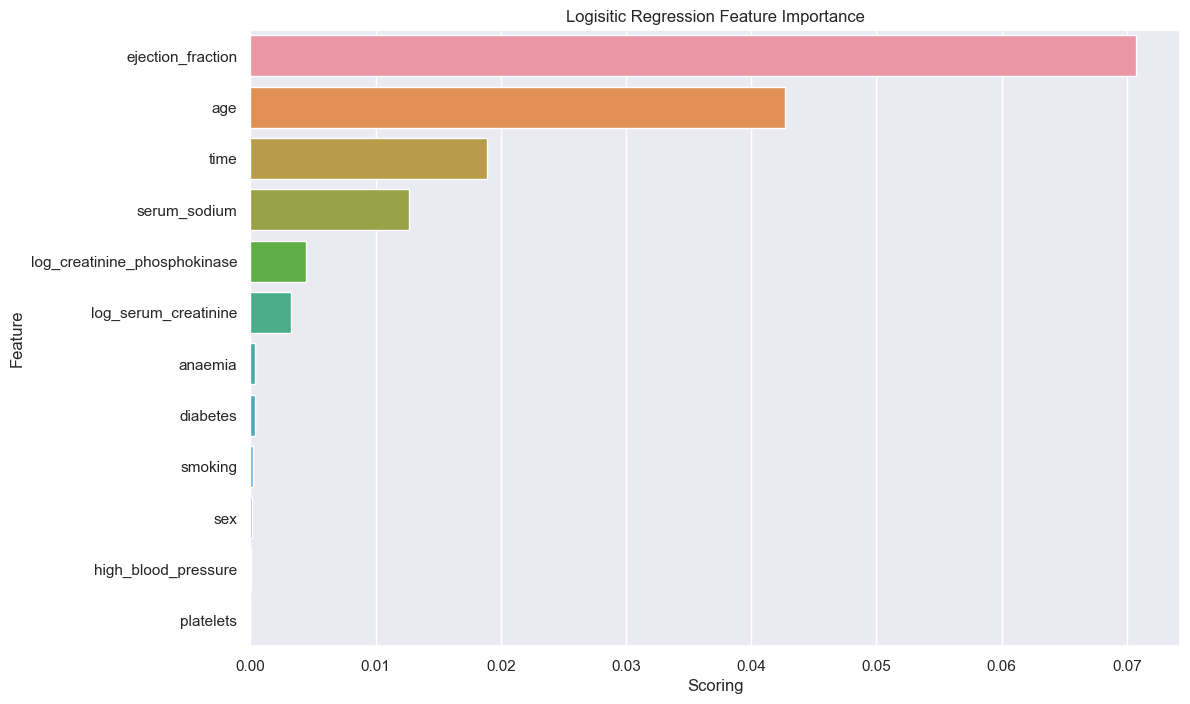

In [162]:
# Logisitic Regression Feature Importance
logisticRegressionImportance(model=LogisticRegression(random_state=0),   # Logisitc Regression Model
                             X=X,                                        # X dataset
                             X_train=X_train,                            # X_train dataset
                             y_train=y_train)                            # y_train dataset

Feature Importance Obersvations-
* We can see that the ejection_fraction have the highest importance when it comes to predicting heartfailure. 
* The second is age.
* Platelet count have almost no effect on heart failure and neither does smoking.
* I do believe that this model represents what would be significant in to most doctors to predicting heart failure.

### Ensemble Model

In [163]:
# Top 3 Classifiers in Results Testing
voting_clf = VotingClassifier(estimators=[ ('Optimized Logisitic Regression',optimized_model),            # 1 Classifier
                                           ('Logistic Regression', LogisticRegression(random_state=0)),   # 2 Classifier
                                           ('GaussianNB',GaussianNB())])                                  # 3 Classifier

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Change Classification to Soft for prediction Probabilties
voting_clf.voting = 'soft'

# Add this model to classifier list
classifier_list.append(voting_clf)
class_name.append('Voting Classifier')

# Run Classification Metrics on all created models
classifierMetrics(classifiers=classifier_list,
                  classifier_name=class_name,
                  X=X,                # X data
                  y=y,                # Y data
                  X_train=X_train,    # X_train Dataset
                  y_train=y_train,    # y_train Dataset
                  X_test=X_test,      # X_test Dataset
                  y_test=y_test,      # y_test Dataset
                  kfolds=5)           # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
11,Voting Classifier,0.776316,0.772529,0.956209,0.727372,0.800000
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
1,GaussianNB,0.736842,0.875000,0.844031,0.800000,0.883333
7,DecisionTreeClassifier,0.842105,0.727273,0.847882,0.780488,0.850000
10,Optimized Logistic Regression,0.736842,0.823529,0.831836,0.777778,0.866667
11,Voting Classifier,0.684211,0.866667,0.817715,0.764706,0.866667
8,RandomForestClassifier,0.736842,0.777778,0.819641,0.756757,0.850000
4,LogisticRegression,0.684211,0.812500,0.805520,0.742857,0.850000
5,AdaBoostClassifier,0.736842,0.736842,0.807445,0.736842,0.833333
2,XGBClassifier,0.684211,0.722222,0.781130,0.702703,0.816667
9,QuadraticDiscriminantAnalysis,0.421053,0.727273,0.673941,0.533333,0.766667
6,KNeighborsClassifier,0.210526,0.444444,0.544288,0.285714,0.666667


Ensemble Testing Obeservations-
* We can see with this model, it slightly under perfoms in the cross-validation when comparing this to Logisitic regression.

####  Ensemble Precision & Recall

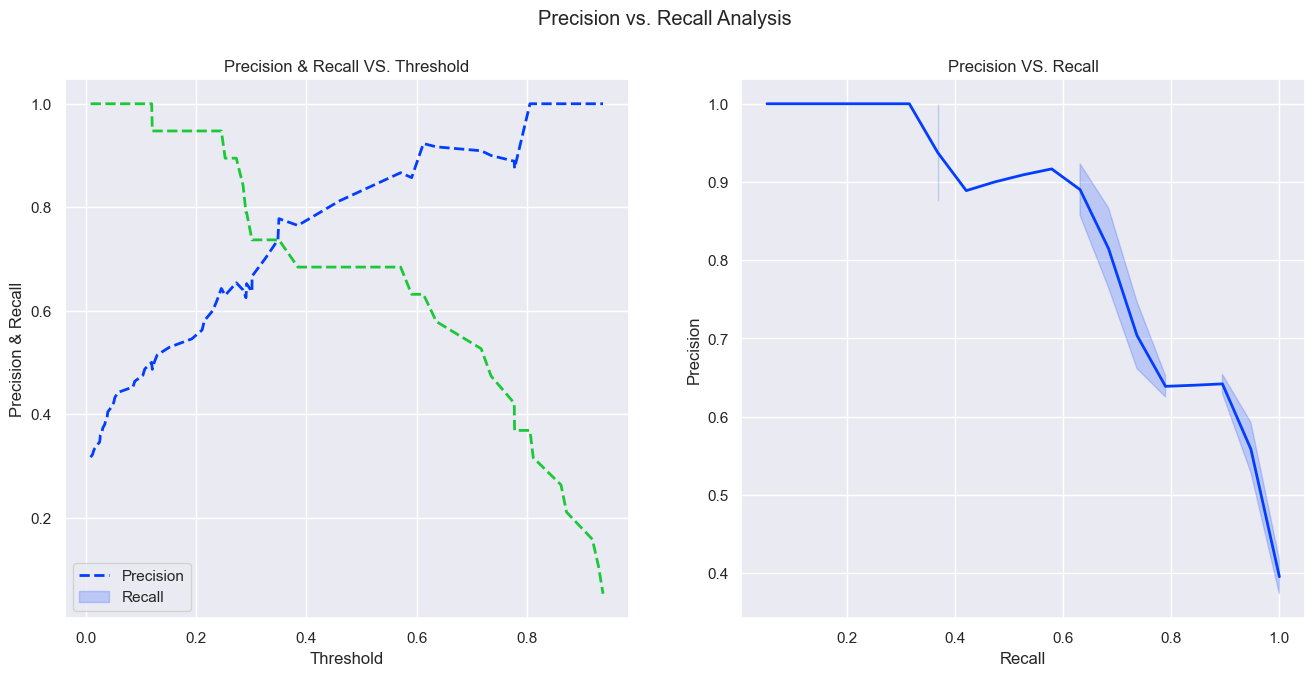

In [164]:
# Predict Probabilities for X_test
y_proba2 = voting_clf.predict_proba(X_test)

# Visualize Pecision & Recall 
precisionRecallAnalysis(y_test, y_proba2)

Ensemble Precision & Recall Observations-
* We can see that tht optimal threshold is just above 0.4. 

## Deep Learning

### Import Necessary Deep Learning Libraries

In [165]:
# Change TensorFlow settings
os.environ['TF_SPP_MIN_LOG_LEVEL'] = '2'                            # Change the logging output level to 2
physical_devices = tf.config.list_physical_devices('GPU')           # Configure the GPU as the device for computations

# Print out TensorFlow Version
print(tf.__version__)
print(physical_devices)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Obeservations-
* Configure tensorflow to use the GPU for faster computations.
* Print out the version and device that is going to be used for computations.

### Scale Values for Deep Learning

In [166]:
# Scale Values for Deep Learning
scaler = StandardScaler()

# Create new Variables for Scaled Values
X_scaled = scaler.fit_transform(X)

##### Obersvations-
* It has been shown that scaling values before computations can both improve speed of computations and scaling the values can have an impact for better results. 
* Since our y values are just binary (either 1 or 0), we do not need to scale those values.

### Create Deep Learning Model

In [167]:
# Set Random Weights Seed for Reproducable Results
tf.random.set_seed(0)

# Set Variables for Deep Learning
EPOCHS = 150
BATCH_SIZE = 20
VALIDATION_SPLIT = .20
INPUT_SHAPE= X_scaled.shape[1]

# ANN Model Build
model = keras.Sequential(name='HeartClassifier_ANN', layers=
    [
        keras.Input(shape=(INPUT_SHAPE,), name='Input Layer'),
        layers.Dense(48, activation='relu', name='Hidden_Layer1'),
        layers.Dropout(.1, name='Dropout_Layer1'),
        layers.Dense(24, activation='relu', name='Hidden_Layer2'),
        layers.Dropout(.1, name='Dropout_Layer2'),
        layers.Dense(4, activation='relu', name='Hidden_Layer3'),
        layers.Dropout(.1, name='Dropout_Layer3'),
        layers.Dense(1, activation='sigmoid', name='Output_Layer')
    ]
)

# Compile Model Attributes
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Show Model Architecture
print(model.summary())

# Train & Fit Model
hist= model.fit(x=X_scaled,                                            
                y=y,                                        
                epochs=EPOCHS,                                        
                batch_size=BATCH_SIZE,                                        
                validation_split=VALIDATION_SPLIT,                                        
                shuffle=True, 
                verbose=0)                                          

# Evaluation Metrics
model_df = pd.DataFrame({ 'Loss': [hist.history['loss'][-1]],
                           'Accuracy': [hist.history['accuracy'][-1]],
                           'Validation Loss': [hist.history['val_loss'][-1]],
                           'Validation Accuracy': [hist.history['val_accuracy'][-1]]})

# Display Model Results
print('\n\n Deep Learning Model Metrics')
display(model_df)

Model: "HeartClassifier_ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer1 (Dense)        (None, 48)                624       
_________________________________________________________________
Dropout_Layer1 (Dropout)     (None, 48)                0         
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 24)                1176      
_________________________________________________________________
Dropout_Layer2 (Dropout)     (None, 24)                0         
_________________________________________________________________
Hidden_Layer3 (Dense)        (None, 4)                 100       
_________________________________________________________________
Dropout_Layer3 (Dropout)     (None, 4)                 0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)         

,Loss,Accuracy,Validation Loss,Validation Accuracy
0,0.115651,0.970711,0.264239,0.95


##### Obersvations-
* We set our variables early so that we can change them quickly when building multiple models. 
* There are 3 points of drop out to minimize overfitting for the results.
* This is a smaller Neural Network with only 1,905 parameters.
* The model architecture is kept simple to minimize overfitting and keep it simple.
* Please note that in my machine learning models I used kfold cross validation to show the results in a statistical approach. But in this I am using still 20% of my dataset as validation data in this model as well.

## Final Model Analysis

In [168]:
# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # Classification list
                  classifier_name=class_name,    # Classifier name
                  X=X,                           # X data
                  y=y,                           # Y data
                  X_train=X_train,               # X_train Dataset
                  y_train=y_train,               # y_train Dataset
                  X_test=X_test,                 # X_test Dataset
                  y_test=y_test,                 # y_test Dataset
                  kfolds=5)                      # of K-folds 


# Deep Learning Model Metrics
print('\n\n Deep Learning Model Metrics')
display(model_df)

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
11,Voting Classifier,0.776316,0.772529,0.956209,0.727372,0.800000
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
1,GaussianNB,0.736842,0.875000,0.844031,0.800000,0.883333
7,DecisionTreeClassifier,0.842105,0.727273,0.847882,0.780488,0.850000
10,Optimized Logistic Regression,0.736842,0.823529,0.831836,0.777778,0.866667
11,Voting Classifier,0.684211,0.866667,0.817715,0.764706,0.866667
8,RandomForestClassifier,0.736842,0.777778,0.819641,0.756757,0.850000
4,LogisticRegression,0.684211,0.812500,0.805520,0.742857,0.850000
5,AdaBoostClassifier,0.736842,0.736842,0.807445,0.736842,0.833333
2,XGBClassifier,0.684211,0.722222,0.781130,0.702703,0.816667
9,QuadraticDiscriminantAnalysis,0.421053,0.727273,0.673941,0.533333,0.766667
6,KNeighborsClassifier,0.210526,0.444444,0.544288,0.285714,0.666667




 Deep Learning Model Metrics


,Loss,Accuracy,Validation Loss,Validation Accuracy
0,0.115651,0.970711,0.264239,0.95


#### Final Observations-
* Looking through the machine learning and deep Learning models we can conclude that the deep learning model is FAR superior at over 15% more accuracy than the top performing machine learning models. 
* Please note that I chose not to use Kfolds or cross validation with the Deep Learning Model since I took 20% of the data during training and used that as validation. So when comparing to the results of the machine learning models during the cross validation I took 1/5 of the data and used that as our validation/test set. Therefore I feel that these two different models are well compared. 
* Lastly we can note that there is just a alittle more than a 8% diffrence between the GaussianNB model and the Deep Learning model when compareing the actual training and test results. 


#### Machine Learning Importance Analysis

   Logisitic Regression Feature Importance
----------------------------------------


,index,Feature,Scoring
0,3,ejection_fraction,0.069784
1,0,age,0.048569
2,9,time,0.019921
3,6,serum_sodium,0.009653
4,10,log_creatinine_phosphokinase,0.003962
5,11,log_serum_creatinine,0.003292
6,8,smoking,0.000265
7,2,diabetes,0.000236
8,4,high_blood_pressure,0.000117
9,7,sex,0.000090


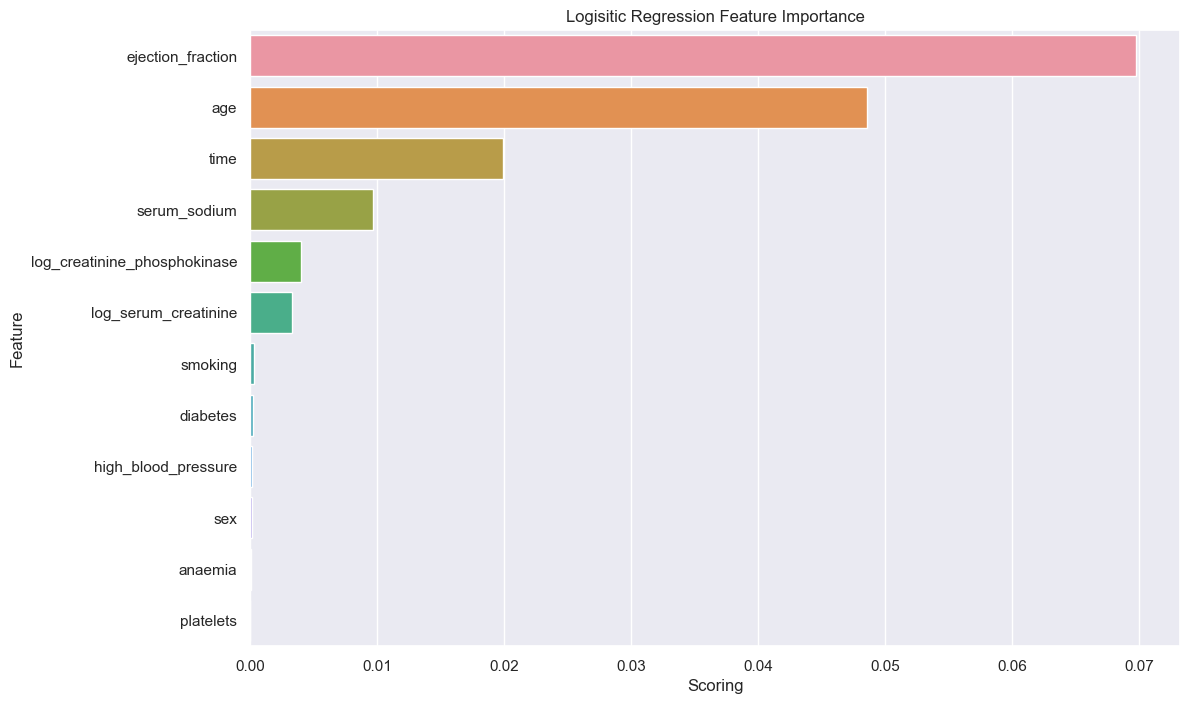

In [169]:
# Logisitic Regression Feature Importance
logisticRegressionImportance(model=LogisticRegression(random_state=0),   # Logisitc Regression Model
                             X=X,                                        # X dataset
                             X_train=X,                                  # X_train dataset
                             y_train=y)                                  # y_train dataset

Importance Analysis Observations-
<ul>
    <li> After running our Logisitic Regression Calculations, we can find that the most imporant feature of this dataset it the ejection Fraciton.</li>
    <li> We can see that the bottom 4 features add almost nothing to the dataset.</li>

</ul>

#### Deep Learning Feature Importance Analysis

,Feature,Importance
9,time,11.365862
11,log_serum_creatinine,10.793410
10,log_creatinine_phosphokinase,9.496035
6,serum_sodium,9.209442
1,anaemia,9.017889
3,ejection_fraction,8.988402
8,smoking,8.935308
4,high_blood_pressure,8.891150
5,platelets,8.825287
7,sex,7.633957


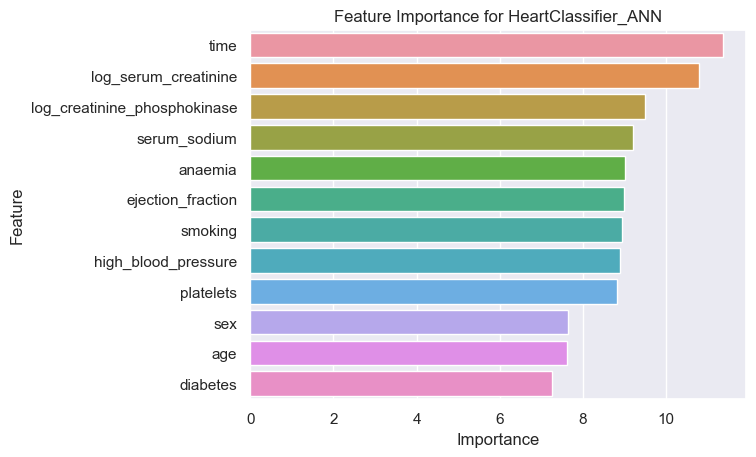

In [170]:
# IMPORTANCE FUNCTIONS
def DeepLearningImportance(model, X):
    '''
    Title: Deep Learning Feature Importance
    Description: This will display a pandas data frame of first weights of inputs for your deep learning model
                 and then plot a chart showing those relationships graphically.
    model: Keras Deep Learning Model
    X: X Dataset 
    '''
    # Create title for Chart
    title = 'Feature Importance for '+ model.name

    # Get all weights from Deep Learning Model
    weights = model.get_weights()

    # Normalize those weights for the input layer
    feature_importance_keras = np.sum(np.abs(weights[0]),axis=1)

    # Create a dictionary to convert to a Pandas Dataframe
    importance_data = {'Feature': X.columns.values,
                       'Importance': feature_importance_keras}

    # Create Pandas DataFrame & Sort by Importance
    importance_df = pd.DataFrame(importance_data)
    importance_df= importance_df.sort_values('Importance', ascending = False)

    # Display & Sort results
    display(importance_df)

    # Create Barchart
    sns.barplot(data=importance_df,
                    x='Importance',
                    y='Feature',
                    orient='h')
    
    # Title for chart
    plt.title(title)
    
# Create Feature Importance Dataframe and Chart
DeepLearningImportance(model, X)

#### Observations-
* We can see that time is the most important feature when predicting heart failure. This would make sense, because the longer without seeing your doctor for a check up, the higher the chance of dying is. 

## Save Model for further predictions

#### Saving Logistic Regression Model

In [174]:
# Fit final model
final_model = LogisticRegression(random_state=0)
final_model.fit(X,y)

# Save model as pickle for further use
pd.to_pickle(final_model, './HeartClassifierLR.pickle')

# Verify that it works.
heart_failure_model = pd.read_pickle('./HeartClassifierLR.pickle')
result = heart_failure_model.predict(X_train.head(1))
probability = heart_failure_model.predict_proba(X_train.head(1))

# Print Out Test results
print('Correct Answer:', y_train.iloc[0])
print('Logistic Regression Prediction:',result)
print('Logistic Regression Probability:',probability[0][1])

Correct Answer: 0
Logistic Regression Prediction: [0]
Logistic Regression Probability: 0.010864956006984337


#### Saving Deep Learning Model 

In [172]:
# Import Pickle for Dumping & Loading 
from pickle import dump, load

# Save the Heart Failure Standard Scaler
dump(scaler, open('HeartFailure-Scaler.pkl','wb'))

# Save Heart Failure Deep Learning Model
model.save("HeartClassifier_ANN.h5")

# Load In Saved Scaler
scaler_loaded = load(open('HeartFailure-Scaler.pkl', 'rb'))

# Test Outputs for Original and Loaded Scalers
X_train_loaded_scaled = scaler_loaded.transform(X_train.head(1))
print('Loaded Scaler Values: ', X_train_loaded_scaled)

# Original Scaler 
X_train_orig_scaled = scaler.transform(X_train.head(1))
print('Original Scaler Values: ', X_train_orig_scaled)

# Show the answer for that prediction
print('\n\nCorrect Prediction:', y_train.iloc[0])

# Test Deep Learning Model Output
print('Deep Learning Model Prediction:',model.predict(X_train_loaded_scaled))

Loaded Scaler Values:  [[-0.9123354  -0.87110478 -0.84757938  2.02423362  1.35927151 -1.19169784
   0.76606383  0.73568819  1.4541607   0.79679526  0.62388416 -0.93231103]]
Original Scaler Values:  [[-0.9123354  -0.87110478 -0.84757938  2.02423362  1.35927151 -1.19169784
   0.76606383  0.73568819  1.4541607   0.79679526  0.62388416 -0.93231103]]


Correct Prediction: 0
Deep Learning Model Prediction: [[1.2299983e-10]]
